<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# A Generalizable CNN to Decode Intended Saccade Direction from Macaque PFC Microelectrode Recordings

Please see the 04_ notebook to understand the CNN model used to decode intended saccade direction from spike trains.

In this notebook, we will use the same model architecture, but during training we will feed it data from multiple sessions, comprising both monkeys and 3 different 32-channel banks of electrodes for each monkey. In our architecture, the DepthwiseConv2D layer is a spatial filter that is expected to be unique to each bank of electrodes, thus we will train 6 different models that share all layers except for the spatial filter layer unique to each model.

https://www.tensorflow.org/beta/guide/keras/functional#sharing_layers


### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    # TODO: Clone IntracranialNeurophysDL repository and add to path
    # TODO: Clone MonkeyPFC repository and cd there
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --single-branch --branch cboulay/macaque_pfc --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-rc0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
    # Add IntracranialNeurophysDL repository to path.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'IntracranialNeurophysDL'
    sys.path.append(str(indl_path))
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell, reset_keras, turbo_cmap
%load_ext tensorboard
plt.rcParams.update({'font.size': 16})

## Preparing Data

We are going to use data from multiple sessions, defined in the `sess_infos` list.
Each name * electrode bank will get its own model.

In [2]:
import pandas as pd
sess_infos = [
    {'name': 'JerryLee', 'bank': 'A', 'name_short': 'j', 'date': '090601', 'exp_code': 'sra3_2_j_037_00+03', 'nsx': 'datafile003.ns2'},
    {'name': 'JerryLee', 'bank': 'C', 'name_short': 'j', 'date': '090622', 'exp_code': 'sra3_2_j_049_00+02', 'nsx': 'datafile002.ns2'},
    {'name': 'JerryLee', 'bank': 'A', 'name_short': 'j', 'date': '090623', 'exp_code': 'sra3_1_j_050_00+', 'nsx': 'datafile002.ns2'},
    {'name': 'JerryLee', 'bank': 'B', 'name_short': 'j', 'date': '090624', 'exp_code': 'sra3_1_j_051_00+', 'nsx': 'datafile002.ns2'},
    {'name': 'JerryLee', 'bank': 'C', 'name_short': 'j', 'date': '090625', 'exp_code': 'sra3_1_j_052_00+', 'nsx': 'datafile003.ns2'},
    {'name': 'Marty', 'bank': 'A', 'name_short': 'm', 'date': '090908', 'exp_code': 'sra3_1_m_070_00+02', 'nsx': 'datafile001.ns2'},
    {'name': 'Marty', 'bank': 'A', 'name_short': 'm', 'date': '090914', 'exp_code': 'sra3_1_m_074_00+01', 'nsx': 'datafile001.ns2'},
    {'name': 'Marty', 'bank': 'B', 'name_short': 'm', 'date': '090918', 'exp_code': 'sra3_1_m_076_00+01', 'nsx': 'datafile001.ns2'},
#     {'name': 'Marty', 'bank': 'C', 'name_short': 'm', 'date': '090919', 'exp_code': 'sra3_1_m_077_00+01', 'nsx': 'datafile001.ns2'},
#     {'name': 'Marty', 'bank': 'B', 'name_short': 'm', 'date': '090920', 'exp_code': 'sra3_1_m_078_00+01', 'nsx': 'datafile001.ns2'},
    {'name': 'Marty', 'bank': 'C', 'name_short': 'm', 'date': '090921', 'exp_code': 'sra3_1_m_079_00+01', 'nsx': 'datafile001.ns2'},
    {'name': 'Marty', 'bank': 'A', 'name_short': 'm', 'date': '090922', 'exp_code': 'sra3_1_m_080_00+01', 'nsx': 'datafile001.ns2'},
#     {'name': 'Marty', 'bank': 'B', 'name_short': 'm', 'date': '090925', 'exp_code': 'sra3_1_m_081_00+01', 'nsx': 'datafile001.ns2'},
    {'name': 'Marty', 'bank': 'A', 'name_short': 'm', 'date': '090926', 'exp_code': 'sra3_1_m_082_00+01', 'nsx': 'datafile001.ns2'},
#     {'name': 'Marty', 'bank': 'C', 'name_short': 'm', 'date': '090927', 'exp_code': 'sra3_1_m_083_00+01', 'nsx': 'datafile001.ns2'},
    {'name': 'Marty', 'bank': 'A', 'name_short': 'm', 'date': '090928', 'exp_code': 'sra3_1_m_084_00+01', 'nsx': 'datafile001.ns2'},
#     {'name': 'Marty', 'bank': 'B', 'name_short': 'm', 'date': '090929', 'exp_code': 'sra3_1_m_085_00+01', 'nsx': 'datafile001.ns2'}
]

# Create a pandas dataframe with this information.
col_names = ('name', 'bank', 'exp_code')
data = [[row[col_name] for col_name in col_names] for row in sess_infos]
sess_df = pd.DataFrame(data=data, columns=col_names)

# Identify the unique combinations of monkey name and electrode bank.
sess_cfgs = sess_df.loc[:, ['name', 'bank']].drop_duplicates()
print(sess_cfgs)

       name bank
0  JerryLee    A
1  JerryLee    C
3  JerryLee    B
5     Marty    A
7     Marty    B
8     Marty    C


### Download the data (if necessary)

In [3]:
# Download and unzip data
if IN_COLAB:
    datadir = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    datadir = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (datadir).is_dir():
    !kaggle datasets download --unzip --path {str(datadir)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


### Data loading and splitting

For each session, we are going to use 90% of the data for training and 10% of the data for validation. We will keep the same training/validation split for each epoch, so we will go through the data and get the train/valid indices now. This requires loading each dataset temporarily to pass it into the splitter.

In [4]:
from misc import load_macaque_pfc
from sklearn.model_selection import StratifiedShuffleSplit

P_TRAIN = 0.8

n_timestamps = None
n_channels = None

train_valid_inds = []
for idx, row in sess_df.iterrows():
    sess_id = row['exp_code'].replace('+', '')
    X, Y, ax_info = load_macaque_pfc(datadir, sess_id, x_chunk='spiketrains', zscore=False)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - P_TRAIN, random_state=0)
    train_valid_inds.append(next(sss.split(X, Y)))
    
    # We will also take this opportunity to make sure that all data sets have the same n_timestamps and n_channels
    if n_timestamps is None:
        n_timestamps, n_channels = X.shape[1:]
    if (n_timestamps != X.shape[1]) or (n_channels != X.shape[2]):
        raise ValueError("Inconsistent data shape!")

In [5]:
print("Found {} sessions.".format(len(train_valid_inds)))
print("Each session has {} timestamps and {} channels.".format(n_timestamps, n_channels))
print("Training / validation splits:")
print([(len(_[0]), len(_[1])) for _ in train_valid_inds])

Found 12 sessions.
Each session has 1650 timestamps and 32 channels.
Training / validation splits:
[(357, 90), (403, 101), (793, 199), (849, 213), (789, 198), (822, 206), (839, 210), (799, 200), (769, 193), (926, 232), (823, 206), (924, 231)]


### Preparing data for deep learning

The following function will be called on each dataset when it is loaded to modify the data to be more suitable for deep learning.

In [6]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        x_dat = tf.cast(x_dat, tf.float32)
        x_dat = tf.expand_dims(x_dat, -1)  # Prepare as an image, with only 1 colour channel.
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)  # , drop_remainder=True?
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

## Define Models

One model for each combination of monkey name and electrode bank, but all models will share almost all layers except those associated with the spatial filter.

In [35]:
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers
from collections import OrderedDict
from functools import partial

def make_models(T, C, aug_offset=50,
                k_spike_short=4, l_spike_short=22,
                k_spike_long=2, l_spike_long=200,
                depth_multiplier=4,
                activation='relu',
                dowsamp_1=10,
                dropout_rate=0.45,
                n_pointwise_filters=20,
                kern_length_2=40,
                downsamp_2=5,
                norm_rate=0.45,
                l2_reg=0.001
                ):
    
    # Shared Head
    shared_input_1 = tf.keras.Input(shape=(T - aug_offset, C, 1))
    spk_short = layers.Conv2D(k_spike_short, (l_spike_short, 1), padding='same',
                              use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg))(shared_input_1)
    spk_long = layers.Conv2D(k_spike_long, (l_spike_long, 1), padding='same',
                             use_bias=False,
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg))(shared_input_1)
    shared_output_1 = layers.Concatenate(axis=-1)([spk_short, spk_long])
    shared_head = tf.keras.Model(inputs=shared_input_1, outputs=shared_output_1, name='shared_head')
    
    # Shared Tail
    shared_input_2 = tf.keras.Input(shape=(T - aug_offset, 1,
                                           (k_spike_short + k_spike_long) * depth_multiplier))
    _y = layers.AveragePooling2D((dowsamp_1, 1))(shared_input_2)
    _y = layers.Dropout(dropout_rate)(_y)
    
    _y = layers.SeparableConv2D(n_pointwise_filters, (kern_length_2, 1), padding='valid',
                                depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                pointwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                use_bias=False)(_y)
    _y = layers.Activation(activation)(_y)
    _y = layers.BatchNormalization(axis=1)(_y)
    _y = layers.AveragePooling2D((downsamp_2, 1))(_y)
    _y = layers.Dropout(dropout_rate)(_y)
      
    _y = layers.Flatten()(_y)
    _y = layers.Dense(8, kernel_constraint=max_norm(norm_rate))(_y)
    shared_output_2 = layers.Activation('softmax')(_y)
    shared_tail = tf.keras.Model(inputs=shared_input_2, outputs=shared_output_2, name='shared_tail')
    
    cfg_models = {}
    for cfg_idx, cfg in sess_cfgs.iterrows():
        cfg_model_name = cfg['name'] + '_' + cfg['bank']
        shared_input = tf.keras.Input(shape=(T - aug_offset, C, 1))
        _y = shared_head(shared_input)
        _y = layers.DepthwiseConv2D((1, C), use_bias=False, depth_multiplier=depth_multiplier,
                            depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                            depthwise_constraint=max_norm(1.))(_y)
        _y = layers.Activation(activation)(_y)
        _y = layers.BatchNormalization(axis=1)(_y)
        _y = layers.Dropout(dropout_rate)(_y)
        _y = shared_tail(_y)
        cfg_model = tf.keras.Model(inputs=shared_input, outputs=_y, name=cfg_model_name)
        cfg_model.compile(loss='sparse_categorical_crossentropy',
                          optimizer='RMSprop', metrics=['accuracy'])
        cfg_models[cfg_model_name] = cfg_model
    
    return shared_head, shared_tail, cfg_models


In [36]:
MAX_OFFSET = 50
shared_head, shared_tail, cfg_models = make_models(n_timestamps, n_channels, aug_offset=MAX_OFFSET)
shared_head.summary()
shared_tail.summary()
cfg_models['JerryLee_A'].summary()

Model: "shared_head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1600, 32, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1600, 32, 4)  88          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1600, 32, 2)  400         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1600, 32, 6)  0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]         

## Train our models

In [38]:
BATCH_SIZE = 10
N_EPOCHS_IN_SESS = 20
N_EPOCHS_ACROSS_SESS = 5

In [39]:
hists = {}
for ep_ix in range(N_EPOCHS_ACROSS_SESS):
    for idx in np.random.permutation(len(sess_df)):
        row = sess_df.loc[idx]
        # Load data for this session
        sess_id = row['exp_code'].replace('+', '')
        X, Y, ax_info = load_macaque_pfc(datadir, sess_id, x_chunk='spiketrains', zscore=False)

        # Prepare the data for DL
        trn, vld = train_valid_inds[idx]
        ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, vld, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
        
        # Get/build the model for this session. The weights should carry over from previous learning.
        cfg_model_name = row['name'] + '_' + row['bank']
        
        # Train model
        print("Training model {} on {} ({} of {})".format(cfg_model_name, sess_id,
                                                          ep_ix + 1, N_EPOCHS_ACROSS_SESS))
        history = cfg_models[cfg_model_name].fit(x=ds_train,
                                                 epochs=N_EPOCHS_IN_SESS,
                                                 validation_data=ds_valid,
                                                 verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(history.history['accuracy'][-1],
                                                      history.history['val_accuracy'][-1]))
        if row['exp_code'] not in hists:
            hists[row['exp_code']] = []
        hists[row['exp_code']].append(history.history)

Training model Marty_B on sra3_1_m_076_0001 (1 of 5)
Ending acc and val acc: 0.741, 0.710
Training model JerryLee_B on sra3_1_j_051_00 (1 of 5)
Ending acc and val acc: 0.808, 0.779
Training model JerryLee_A on sra3_1_j_050_00 (1 of 5)
Ending acc and val acc: 0.891, 0.774
Training model Marty_A on sra3_1_m_082_0001 (1 of 5)
Ending acc and val acc: 0.811, 0.757
Training model Marty_A on sra3_1_m_080_0001 (1 of 5)
Ending acc and val acc: 0.699, 0.642
Training model Marty_C on sra3_1_m_079_0001 (1 of 5)
Ending acc and val acc: 0.746, 0.653
Training model Marty_A on sra3_1_m_070_0002 (1 of 5)
Ending acc and val acc: 0.790, 0.694
Training model JerryLee_A on sra3_2_j_037_0003 (1 of 5)
Ending acc and val acc: 0.806, 0.589
Training model JerryLee_C on sra3_2_j_049_0002 (1 of 5)
Ending acc and val acc: 0.808, 0.545
Training model Marty_A on sra3_1_m_074_0001 (1 of 5)
Ending acc and val acc: 0.775, 0.705
Training model Marty_A on sra3_1_m_084_0001 (1 of 5)
Ending acc and val acc: 0.833, 0.749
Tr

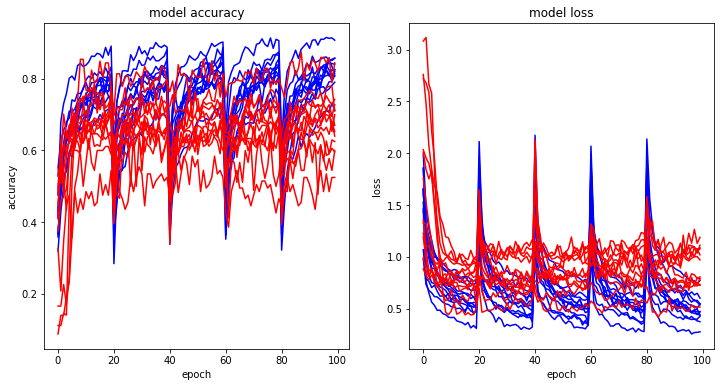

In [40]:
agg_hists = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
for idx, row in sess_df.iterrows():
    for k in agg_hists.keys():
        agg_hists[k].append(np.hstack([_[k] for _ in hists[row['exp_code']]]))
for k in agg_hists.keys():
    agg_hists[k] = np.vstack(agg_hists[k])

fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(agg_hists['accuracy'].T, 'b')
plt.plot(agg_hists['val_accuracy'].T, 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(agg_hists['loss'].T, 'b')
plt.plot(agg_hists['val_loss'].T, 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Our goal is for the deep model to do at least as well as logistic regression, which gave cross-validated classification accuracies of ~60% and ~81% in two datasets. Using the EEGNet CNN, we achieve 74% and 85%. The improvement on the first dataset improves classification above the unofficial threshold for acceptable BCI performance.

We expect the deep model will be useful in other ways too.

In [34]:
if True:
    for idx, row in sess_df.iterrows():
        cfg_model_name = row['name'] + '_' + row['bank']
        reset_keras(cfg_models[cfg_model_name])
    reset_keras(shared_head)
    reset_keras(shared_tail)

8240
184
184
184
184
184
184
184
184
184
184
184
184
184


## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)



In [9]:
# Load the 'best' model from disk.
reset_keras(model)
from tensorflow.keras.models import load_model
model = load_model(datadir / (SESS_ID + '_model_best_all.h5'))
# model.summary()

190


### t-Distributed Stochastic Neighbour Embedding (t-SNE)

https://distill.pub/2016/misread-tsne/

From [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

We will compare the t-SNE projections of the outputs to the projections of the inputs.
However, the raw spiketrains do not decompose to very well so for inputs we will use spikerates that are previously derived from the spike trains convolved with a gaussian kernel (sigma=50 msec).

In [10]:
# Load spike rates for 
rates_X, rates_Y, rates_ax_info = load_macaque_pfc(datadir, SESS_ID, x_chunk='spikerates', zscore=True)
print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    len(rates_ax_info['instance_data']), len(rates_ax_info['timestamps']),
    rates_ax_info['timestamps'][0], rates_ax_info['timestamps'][-1], rates_ax_info['fs'], rates_X.shape[-1]))

Found 1049 trials, 166 timestamps (-0.2 to 1.45 at 100.0 Hz), 32 channels


2921


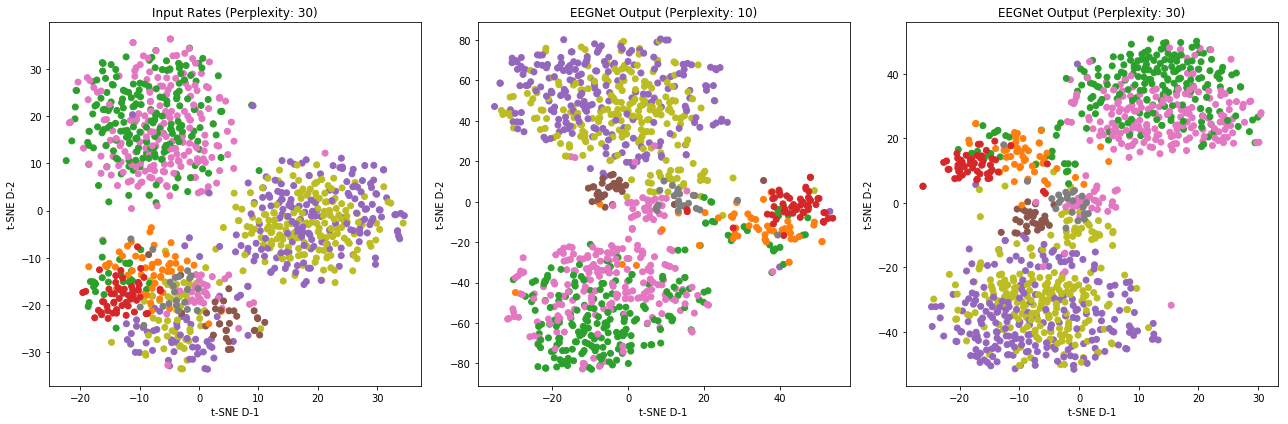

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))
class_colors = np.array([next(colour_codes) for _ in range(10)])
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])

TEST_PERPLEXITY = [10, 30]

fig = plt.figure(figsize=(18, 6), facecolor='white')
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title + ' (Perplexity: {})'.format(perplexity))
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(rates_X.reshape([-1, np.prod(rates_X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(1, 3, 1)
plot_tsne(tsne_values, rates_Y.ravel()+1, TEST_PERPLEXITY[-1], title='Input Rates')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -3
tbs = 30  # tsne batch size
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = []
for start_ix in range(0, X.shape[0], tbs):
    flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]))
flattened_output = tf.concat(flattened_output, 0)
reset_keras(truncated_model)

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(flattened_output)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, Y.ravel()+1, perplexity, title='EEGNet Output')

plt.tight_layout()
fig.savefig(str(datadir / (SESS_ID + '_CNN_tSNE.png')))

t-SNE on the untransformed data shows two different clusters for blue/magenta trial pairs.
These probably came at two different blocks of time, between which there was a change in the neural activations.
After transforming the data, these classes are grouped together.

### First convolutional layers
The first pair of convolutional layers are simply performing time-domain convolutions on the spike trains.
Whereas a typically signal processing pipeline will apply a gaussian, exponentional, or gamma kernel convolution,
here we train the convolution kernels directly. There are separate "short" kernels and "long" kernels.

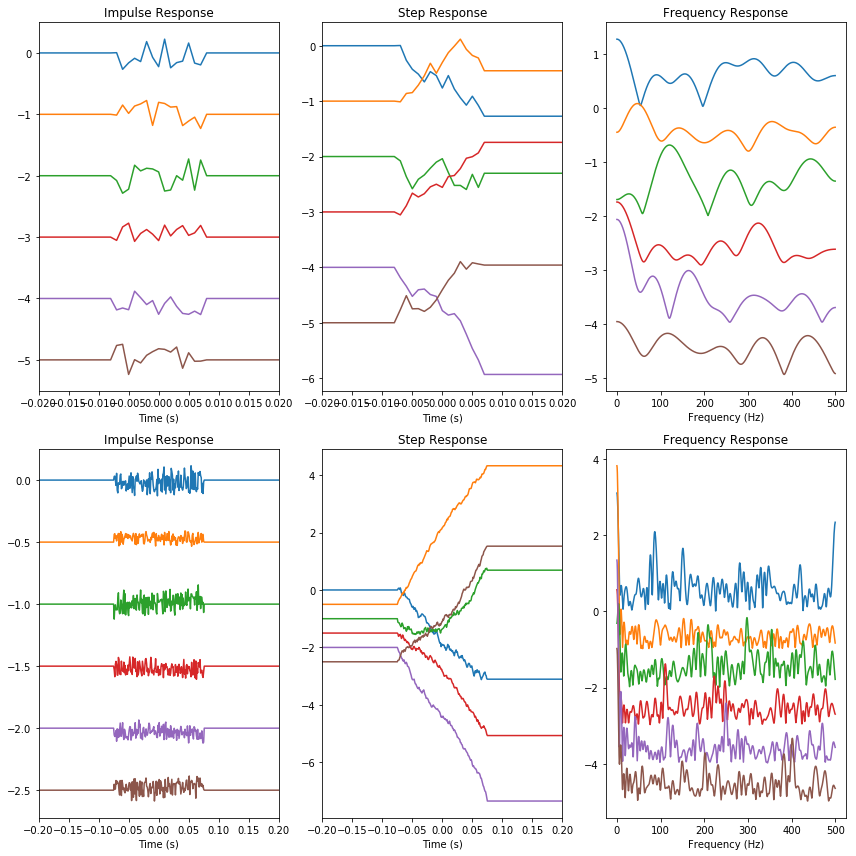

In [25]:
import scipy.signal

fig = plt.figure(figsize=(12, 12), facecolor='white')
t = ax_info['timestamps']

x_ranges = [[-0.02, 0.02], [-0.2, 0.2]]
y_steps = [1.0, 0.5]

impulse = np.zeros_like(t)
impulse[np.argmin(np.abs(t))] = 1.0

step = np.zeros_like(t)
step[np.argmin(np.abs(t)):] = 1.0

for s_l in range(2):
    filters = np.squeeze(model.layers[1 + s_l].get_weights()[0])

    # Impulse response
    plt.subplot(2, 3, 1 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
        plt.plot(t, imp_conv - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Impulse Response')

    # Step response
    plt.subplot(2, 3, 2 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        step_response = scipy.signal.convolve(step, filt_coeff, 'same')
        plt.plot(t, step_response - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Step Response')

    plt.subplot(2, 3, 3 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
        plt.plot(f, np.abs(resp) - filt_ix)
    plt.xlabel('Frequency (Hz)')
    plt.title('Frequency Response')

plt.tight_layout()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

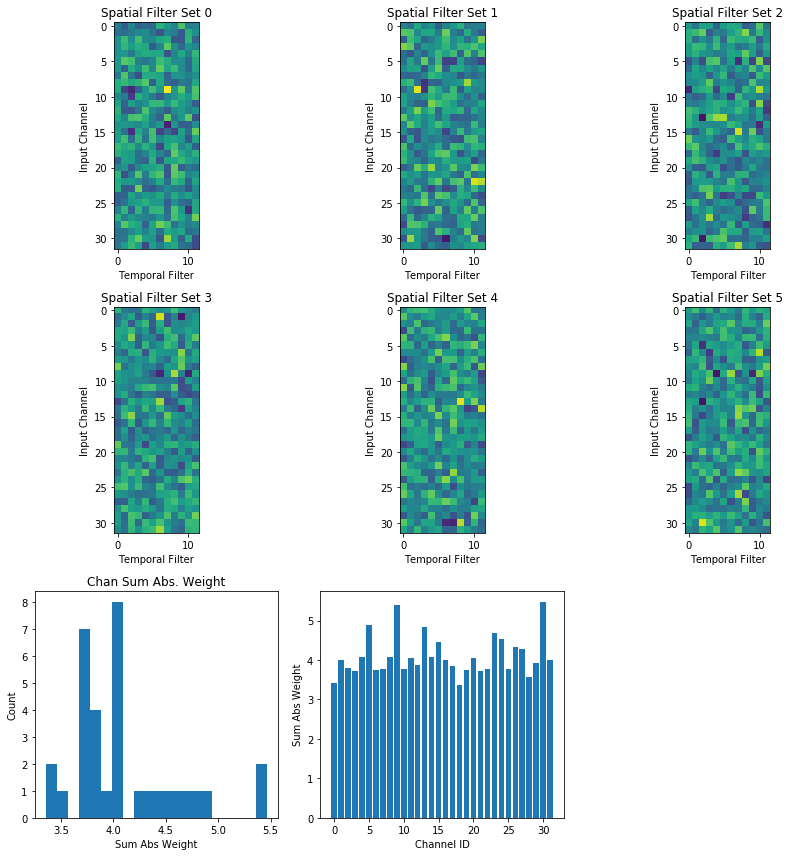

In [27]:
LAYER_IX = 4
spatial_filter = np.squeeze(model.layers[LAYER_IX].get_weights()[0])
D = spatial_filter.shape[-1]
sp_cols = int(np.ceil(np.sqrt(D + 2)))
sp_rows = int(np.ceil((D + 2) / sp_cols))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12), facecolor='white')
for depth_ix in range(D):
    plt.subplot(sp_rows, sp_cols, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()

sum_abs_weight = np.sum(np.sum(np.abs(spatial_filter), axis=1), axis=-1)
plt.subplot(sp_rows, sp_cols, D + 1)
plt.hist(sum_abs_weight, 20)
plt.xlabel('Sum Abs Weight')
plt.ylabel('Count')
plt.title('Chan Sum Abs. Weight')

plt.subplot(sp_rows, sp_cols, D + 2)
plt.bar(np.arange(spatial_filter.shape[0]), sum_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Sum Abs Weight')

plt.tight_layout()
plt.show()

ch_ids = np.argsort(sum_abs_weight)[::-1]  # channel_ids sorted by weight, descending

There seems to be a small group of channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

## Filter Activation-Maximizing Inputs

One useful way to understand what a convolutional layer is doing, especially for deeper layers that are combining abstract features, is to visualize an input that would maximize activation of a filter(s) within the layer.

Remembering back to the step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function for a given set of _inputs_. Now we know the weights but we want to find the inputs that _maximize_ the activation (a.k.a. output) of a filter. We're going to use the same loss-minimization training framework, but instead of calculating a 'loss', we will calculate the mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to maximize output (i.e., step the input up the gradients).

In [35]:
from tensorflow.keras import backend as K

def plot_layer(layer_ix, max_filts=None, n_steps=100):
    in_shape = [1] + model.input.shape.as_list()[1:]
    
    layer_output = model.layers[layer_ix].output
    n_filts = layer_output.shape[-1]
    filt_ids = np.arange(n_filts)
    if (max_filts is not None) and (len(filt_ids) > max_filts):
        filt_ids = filt_ids[np.argsort(np.random.rand(n_filts))][:max_filts]
    
    fig = plt.figure(figsize=(12, 12), facecolor='white')
    sp_cols = int(np.ceil(np.sqrt(len(filt_ids))))
    sp_rows = int(np.ceil(len(filt_ids) / sp_cols))
    
    filt_slice = [np.s_[:] for _ in range(K.ndim(layer_output))]
    
    for ix, filt_ix in enumerate(filt_ids):
        input_data = tf.convert_to_tensor(np.random.randn(*in_shape).astype(np.float32))
        if layer_ix > (len(model.layers) - 3):
            # model.layers[layer_ix].activation == tf.keras.activations.softmax:
            max_model = tf.keras.Model(model.input, layer_output)
            non_targ_id = tf.constant(np.setdiff1d(np.arange(layer_output.shape[-1], dtype=int), filt_ix))
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    targ_act = filter_act[0, filt_ix]
                    nontarg_act = K.mean(tf.gather(filter_act, non_targ_id, axis=-1))
                    loss_value = targ_act - nontarg_act
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        else:
            filt_slice[-1] = filt_ix
            max_model = tf.keras.Model(model.input, layer_output[tuple(filt_slice)])
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    loss_value = K.mean(filter_act)
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        input_data = np.squeeze(input_data)

        plt.subplot(sp_rows, sp_cols, ix + 1)
        plt.plot(t[MAX_OFFSET:], input_data[:, ch_ids[:4]])
        plt.xlabel('Time After Target Onset (s)')
        plt.ylabel('Filter {}'.format(filt_ix))
        plt.title('Output {:.2f}'.format(loss_value.numpy()))
        for xx in [0, 0.25, 1.25]:
            plt.axvline(xx, color='k', linestyle='--')
        
    plt.tight_layout()

In [36]:
# 4 is DepthwiseConv2D, 9 is SeparableConv2D
plot_layer(9, max_filts=9)

Tensor("separable_conv2d/Identity:0", shape=(None, 141, 1, 24), dtype=float32) [slice(None, None, None), slice(None, None, None), slice(None, None, None), 20]


ValueError: Unknown graph. Aborting.

<Figure size 864x864 with 0 Axes>

### Class Maximizing Inputs
If we extend our reasoning from filter activations down to the next-to-last layer (15), and we choose a 'loss' that maximizes one class, we can plot maximization signals for each of the 8 output classes. If we were to do the same on the final Softmax layer (16), the results have a similar shape but are quite noisy because perfect classification is achieved quickly and thus there is no more gradient.

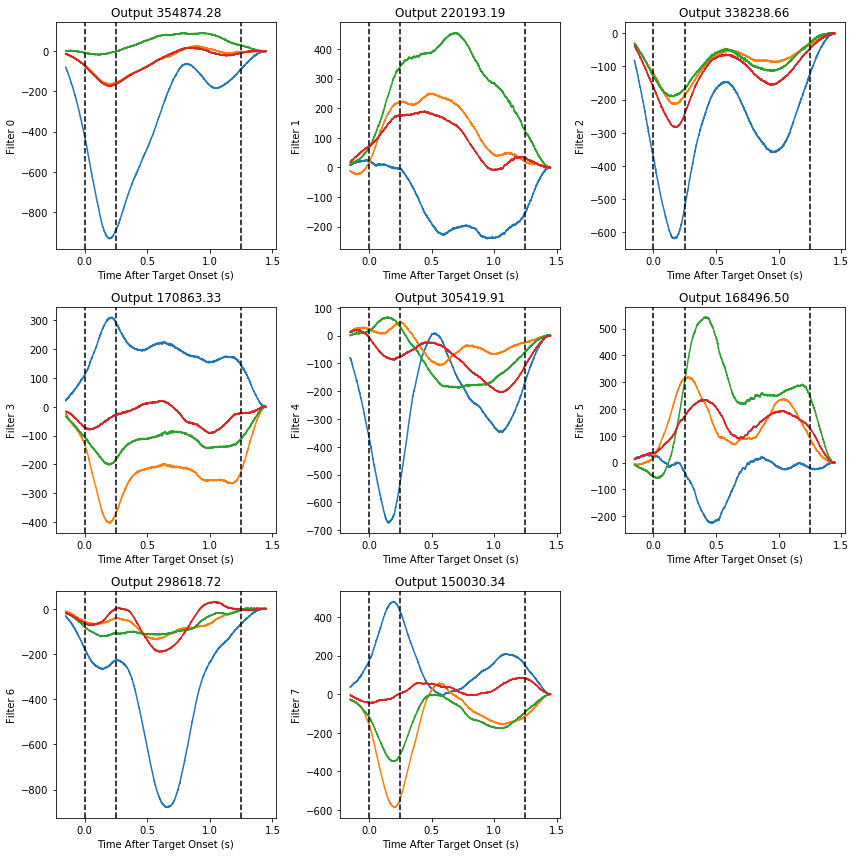

In [52]:
plot_layer(16, n_steps=100)

## Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [53]:
from tensorflow.keras import backend as K
def get_losses_for_class(test_class):
    classes, y = np.unique(Y, return_inverse=True)
    trial_ids = np.where(y == classes.tolist().index(test_class))[0]
    losses_grads = []
    for tr_id in trial_ids:
        input_data = tf.convert_to_tensor(X[tr_id, MAX_OFFSET:, :].astype(np.float32)[None, :, :, None])
        with tf.GradientTape() as tape:
            tape.watch(input_data)
            class_proba = model(input_data)
            loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
        grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
        # Normalize gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
        losses_grads.append((loss_value, grads))
    return losses_grads

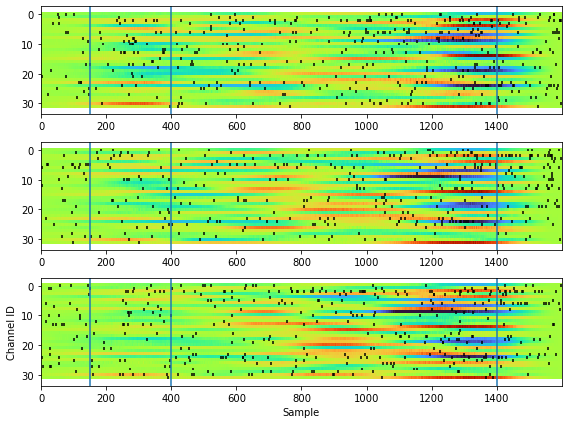

In [54]:
# Plot saliency image for a few trials in a particular class
N_SALIENCY_TRIALS = 3
TEST_CLASS = 5  # -1 to 6
losses_grads = get_losses_for_class(TEST_CLASS)
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
re_ix = np.argsort(loss_vals)
b_class = np.squeeze(Y == TEST_CLASS)
_x = X[b_class, MAX_OFFSET:][re_ix][:N_SALIENCY_TRIALS]
_masks = grad_vals[re_ix][:N_SALIENCY_TRIALS]

fig = plt.figure(figsize=(8, 6), facecolor='white')
for tr_ix in range(N_SALIENCY_TRIALS):
    plt.subplot(N_SALIENCY_TRIALS, 1, tr_ix + 1)
    plt.imshow(_masks[tr_ix].T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    plt.eventplot([np.where(_)[0] for _ in _x[tr_ix].T], colors='k')
    for _t in t0_ix:
        plt.axvline(_t)
plt.xlabel('Sample')
plt.ylabel('Channel ID')
plt.tight_layout()

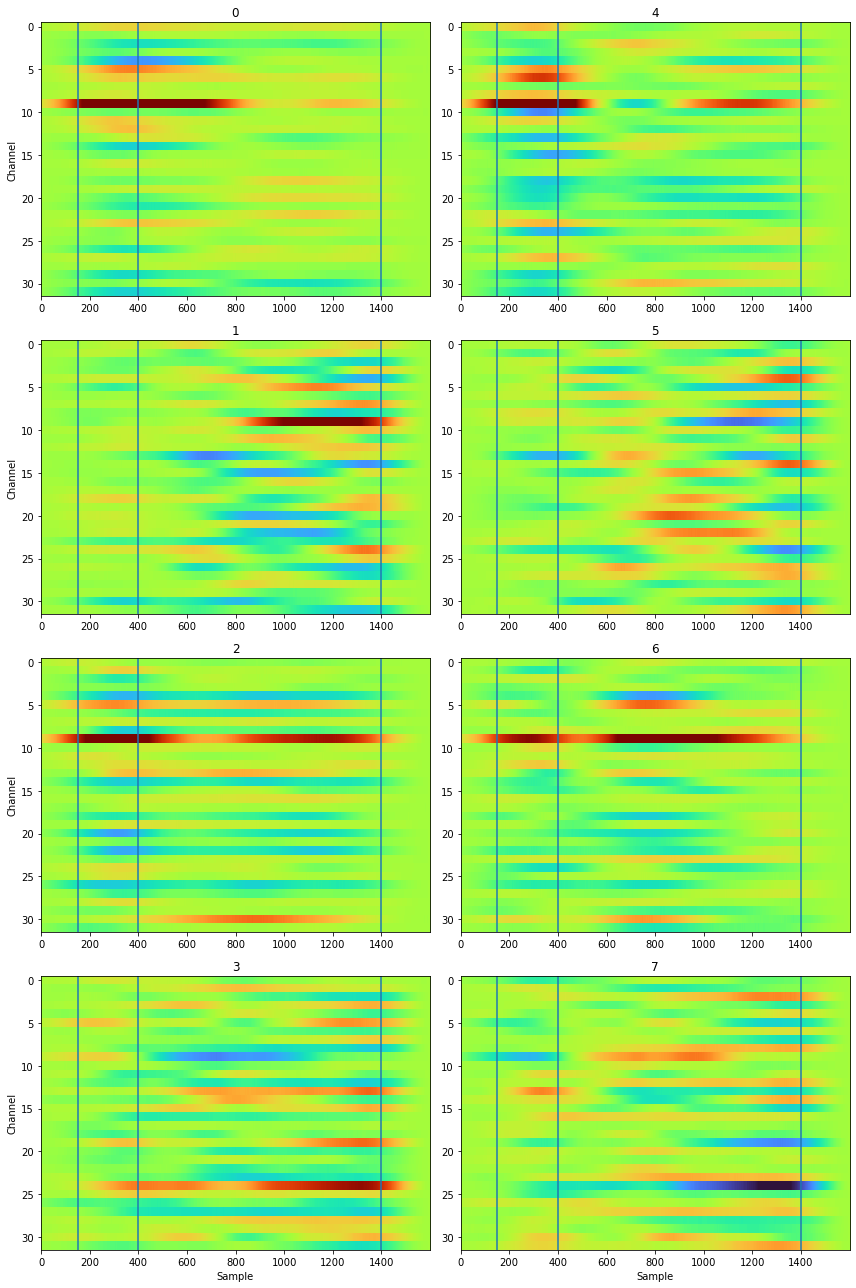

In [55]:
# Plot average saliencies for all trials within each class
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

fig = plt.figure(figsize=(12, 18), facecolor='white')

for ix, class_id in enumerate(np.unique(Y)):
    losses_grads = get_losses_for_class(class_id)
    loss_vals = [_[0][0].numpy() for _ in losses_grads]
    grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
    grad_vals = np.mean(grad_vals, axis=0)
    plot_ix = 2 * ix + 1 * (ix < 4) - 6 * (ix >= 4)
    plt.subplot(4, 2, plot_ix)
    plt.imshow(grad_vals.T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    for _t in t0_ix:
        plt.axvline(_t)
    plt.title(str(class_id))
    if (ix + 1) % 4 == 0:
        plt.xlabel('Sample')
    if ix < 4:
        plt.ylabel('Channel')
plt.tight_layout()

## Class Activation Maps

Class activation maps (CAM) highlight the parts of the input that contribute most to each classification score. This is similar but different to saliency mapping. Whereas in saliency mapping the losses are back-propagated all the way back to the inputs, in CAM (or [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf)) the per-class scores / losses are propaged backward only to the last convolutional layer. These losses are then used as the weights in a weighted average of the feature map output of the last convolutional layer. If the result is smaller than the input, it is then interpolated to match the input size.

Remember that in image classification the data have width pixels x height pixels x colour depths, but in our neural time-series data we have time samples x 1 x electrodes. We could use CAM on our timeseries data to identify which time points are important for each class but not channels because CAM averages across 'depth'. Time-point importance is unlikely to be informative in this dataset because it is unlikely that the timing of processing visual cues and creating motor plans is class-dependent, especially not at the time scales of the final convolution output (~100 msec).

To get any information about which channels of the input were important, we would have to project the losses back to before the spatial filter layer (`DepthwiseConv2D`).

TODO: Cluster channels based on cross-correlations of per-trial saliency maps.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.8

def evaluate_model(params, verbose=0):
    print(params)
    n_spike_kernels = params.get('n_spike_kernels', 4)
    spike_kern_short = params.get('spike_kern_short', 10)
    spike_kern_long = params.get('spike_kern_long', 100)
    D = params.get('D', 8)
    n_pointwise_filters = params.get('n_pointwise_filters', 22)
    kern_length_1 = params.get('kern_length_1', 32)
    downsamp_1 = params.get('downsamp_1', 2)
    norm_rate = params.get('norm_rate', 0.35)
    dropout_rate = params.get('dropout_rate', 0.4)
    l2_reg = params.get('l2_reg', 0.00001)
    epochs = params.get('epochs', 60)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN)
    trn, tst = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET,
                       n_spike_kernels=n_spike_kernels, spike_kern_short=spike_kern_short, spike_kern_long=spike_kern_long,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, kern_length_1=kern_length_1, downsamp_1=downsamp_1,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    min_val_loss = min(history.history['val_loss'])
    print("Min validation loss with these parameters: {}".format(min_val_loss))
    
    reset_keras(model)
    reset_keras(model)  # Just to be sure...
    
    return min_val_loss

In [38]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest


space = {
    'n_spike_kernels': scope.int(hp.quniform('n_spike_kernels', 1, 8, 1)),
    'spike_kern_short': scope.int(hp.quniform('spike_kern_short', 8, 50, 2)),
    'spike_kern_long': scope.int(hp.quniform('spike_kern_long', 60, 250, 5)),
    'D': scope.int(hp.quniform('D', 1, 12, 1)),
    'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
    'kern_length_1': scope.int(hp.quniform('kern_length_1', 4, 64, 1)),
    'downsamp_1': scope.int(hp.quniform('downsamp_1', 2, 9, 1)),
    'norm_rate': hp.uniform('norm_rate', 0., 0.5),
    'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
#     'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(0.1)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
}

trials = Trials()  # object that holds iteration results
#Do optimization
eval_hours = 3.
minutes_per_eval = 2.
max_evals = int(eval_hours * 60 / minutes_per_eval)
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
print("Best Loss: {}".format(trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

{'D': 9, 'downsamp_1': 8, 'dropout_rate': 0.1787865998734841, 'kern_length_1': 28, 'n_pointwise_filters': 62, 'n_spike_kernels': 2, 'norm_rate': 0.3649826281587057, 'spike_kern_long': 110, 'spike_kern_short': 8}
Min validation loss with these parameters: 0.8837369680404663                                                          
23                                                                                                                     
210                                                                                                                    
{'D': 6, 'downsamp_1': 8, 'dropout_rate': 0.42737305730450165, 'kern_length_1': 33, 'n_pointwise_filters': 50, 'n_spike_kernels': 7, 'norm_rate': 0.47713927192191835, 'spike_kern_long': 60, 'spike_kern_short': 20}
Min validation loss with these parameters: 0.6503629010348093                                                          
68425                                                                                         

{'D': 10, 'downsamp_1': 7, 'dropout_rate': 0.14231032962761664, 'kern_length_1': 17, 'n_pointwise_filters': 65, 'n_spike_kernels': 3, 'norm_rate': 0.4966410568566284, 'spike_kern_long': 105, 'spike_kern_short': 8}
Min validation loss with these parameters: 0.8189671039581299                                                          
181615                                                                                                                 
210                                                                                                                    
{'D': 7, 'downsamp_1': 9, 'dropout_rate': 0.3521292166650847, 'kern_length_1': 27, 'n_pointwise_filters': 48, 'n_spike_kernels': 6, 'norm_rate': 0.4297462534352996, 'spike_kern_long': 205, 'spike_kern_short': 32}
Min validation loss with these parameters: 0.7174506783485413                                                          
181615                                                                                       

{'D': 5, 'downsamp_1': 6, 'dropout_rate': 0.4743908686059821, 'kern_length_1': 47, 'n_pointwise_filters': 15, 'n_spike_kernels': 3, 'norm_rate': 0.49762233378362947, 'spike_kern_long': 95, 'spike_kern_short': 14}
Min validation loss with these parameters: 0.7581294150579543                                                          
181615                                                                                                                 
210                                                                                                                    
{'D': 3, 'downsamp_1': 7, 'dropout_rate': 0.4175469224407971, 'kern_length_1': 57, 'n_pointwise_filters': 35, 'n_spike_kernels': 5, 'norm_rate': 0.2960269764311558, 'spike_kern_long': 180, 'spike_kern_short': 50}
Min validation loss with these parameters: 0.7165929618335906                                                          
181615                                                                                        

{'D': 10, 'downsamp_1': 4, 'dropout_rate': 0.4840225415485412, 'kern_length_1': 12, 'n_pointwise_filters': 2, 'n_spike_kernels': 8, 'norm_rate': 0.06673631974364488, 'spike_kern_long': 220, 'spike_kern_short': 18}
Min validation loss with these parameters: 1.0481463017917814                                                          
181615                                                                                                                 
210                                                                                                                    
{'D': 9, 'downsamp_1': 2, 'dropout_rate': 0.3650443940183512, 'kern_length_1': 10, 'n_pointwise_filters': 12, 'n_spike_kernels': 6, 'norm_rate': 0.1793451424270836, 'spike_kern_long': 170, 'spike_kern_short': 32}
Min validation loss with these parameters: 0.7172320655414036                                                          
181614                                                                                       

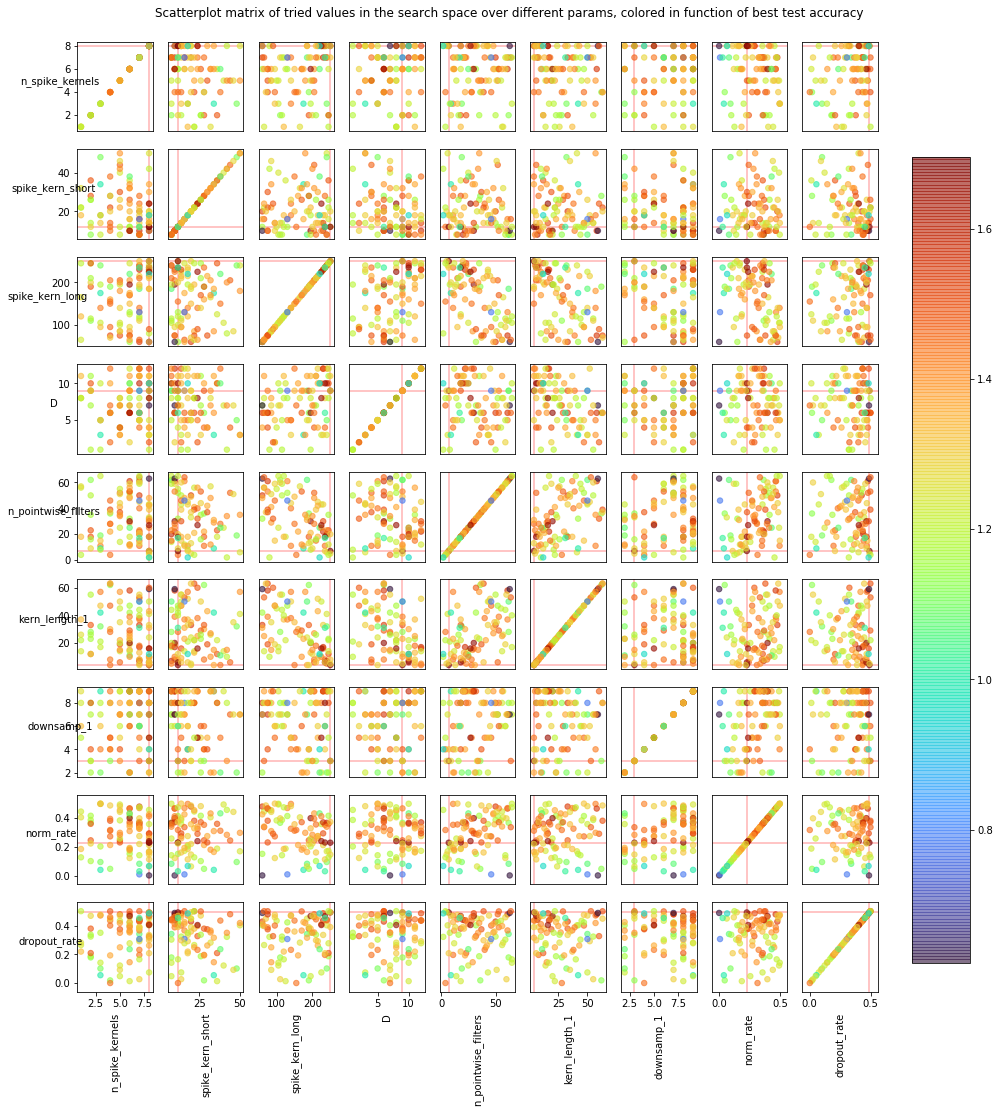

In [46]:
def scatterplot_matrix_colored(params_names, params_values, best_losses, best_trial=None):
    """Scatterplot colored according to the Z values of the points."""
    import matplotlib
    
    nb_params = len(params_values)
    best_losses = np.array(best_losses)
    norm = matplotlib.colors.Normalize(vmin=best_losses.min(), vmax=best_losses.max())
    
    fig, ax = plt.subplots(nb_params, nb_params, figsize=(16, 16))#, facecolor=bg_color, edgecolor=fg_color)
    
    for i in range(nb_params):
        p1 = params_values[i]
        for j in range(nb_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            
            if best_trial is not None:
                axes.axvline(p2[best_trial], color='r', zorder=-1, alpha=0.3)
                axes.axhline(p1[best_trial], color='r', zorder=-1, alpha=0.3)
                
            # Subplot:
            s = axes.scatter(p2, p1, s=30, alpha=0.6,
                             c=best_losses, cmap=turbo_cmap, norm=norm)

            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=0)
            else:
                axes.set_yticks([])
            
            if i == nb_params - 1:
                axes.set_xlabel(params_names[j], rotation=90)
            else:
                axes.set_xticks([])

    fig.subplots_adjust(right=0.82, top=0.95)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of tried values in the search space over different params, colored in function of best test accuracy')
    plt.show()

hp_loss = [1 / (_['result']['loss']) for _ in trials.trials]
hp_names = list(space.keys())
hp_vals = [[_['misc']['vals'][key][0] for _ in trials.trials] for key in hp_names]
if 'l2_reg' in hp_names:
    hp_vals[hp_names.index('l2_reg')] = np.log10(hp_vals[hp_names.index('l2_reg')])
scatterplot_matrix_colored(hp_names, hp_vals, hp_loss, best_trial=trials.best_trial['tid'])

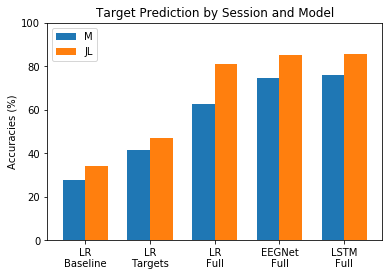

In [70]:
# Grouped bar plots of manually-input data.
monkey_names = ['M', 'JL']
data_types = ['LR\nBaseline', 'LR\nTargets', 'LR\nFull', 'EEGNet\nFull', 'LSTM\nFull']
accuracies = [[27.8, 41.6, 62.7, 74.9, 76.1],[34, 47, 81, 85.2, 85.5]]

ind = np.arange(len(data_types))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
for m_ix, m_name in enumerate(monkey_names):
    ax.bar(ind - width/2 + m_ix * width, accuracies[m_ix], width, label=m_name)

ax.set_ylabel('Accuracies (%)')
ax.set_ylim([0, 100])
ax.set_title('Target Prediction by Session and Model')
ax.set_xticks(ind)
ax.set_xticklabels(data_types)
ax.legend()

fig.savefig(str(datadir / 'converted' / ('Acc_Bars.png')))